# Generalized likelihood ratio tests

Gilles Louppe, February 2016.

For composite hypothesis testing of a null $H_0 : \theta \in \Theta_0$ against an alternative $H_1 : \theta \in \Theta_1$ (such that $\Theta_0 \cap \Theta_1 = \emptyset$ and $\Theta_0 \cup \Theta_1 = \Theta$), we are often interested in evaluating the generalized likelihood ratio test statistic 

$$\lambda(D) = \frac{ sup_{\theta \in \Theta_0} p(D|\theta) } { sup_{\theta \in \Theta} p(D|\theta) }. $$

In the likelihood-free setting, computing $\lambda(D)$ is made difficult because $p(D|\theta)$ cannot be directly evaluated. In this notebook, we show how this statistic can be efficiently approximated using parameterized calibrated classifers, as outlined in [1]: http://arxiv.org/abs/1506.02169.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
plt.set_cmap("viridis")

import numpy as np
import theano
import theano.tensor as T

## Toy problem

Let assume:
- a background density $p_b$ defined as mixture of two 2D multivariate normal distributions $p_{b_0}$ and $p_{b_1}$, for both of which all parameters are assumed to be known, except for some scale factor $\nu$ of $p_{b_0}$'s mean value.
- a signal density $p_s$ defined as single multivariate gaussian, for which all parameters are assumed to be known.

Let consider the model where $x$ is either drawn from the background $p_b$ with probability $1-\alpha$ or drawn
from the signal $p_s$ with probability $\alpha$. 

In this setting, our goal is to test the null hypothesis $H_0: \alpha = 0, \nu \in \mathbb{R}$ (corresponding to the _background only_ hypothesis) against the alternative $H_1 : 0 < \alpha \leq 1, \nu \in \mathbb{R}$ (corresponding to the _background+signal_ hypothesis).

In [51]:
from carl.distributions import MultivariateNormal
from carl.distributions import Mixture

# Assume that data is generated from these values
nu_true = -1.0
alpha_true = 0.2

# Define H0 and H1 models
nu = theano.shared(nu_true, name="nu")
nu_bounds = (-2.0, 2.0)  # Restrict to a subset of \mathbb{R}
alpha = theano.shared(alpha_true, name="alpha")
alpha_bounds = (0.0, 1.0)

p_b = Mixture(components=[
    MultivariateNormal(mu=nu * np.array([1.0, 1.0]), 
                       sigma=np.array([[1.0, 0.3], 
                                       [0.3, 1.0]])),    
    MultivariateNormal(mu=np.array([2.0, 2.0]), 
                       sigma=np.array([[1.0, -0.75], 
                                       [-0.75, 1.0]]))
])

p_s = MultivariateNormal(mu=np.array([0.5, 0.5]), 
                         sigma=np.array([[0.5, -0.25], 
                                         [-0.25, 0.5]]))

p_H0 = p_b
p_H1 = Mixture(components=[p_b, p_s], weights=[1.0 - alpha, alpha])

/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


How does that look?

In [52]:
def plot_data(X):
    h = plt.hist2d(X[:, 0], X[:, 1], bins=50, range=[(-4, 4), (-4, 4)])
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.show()

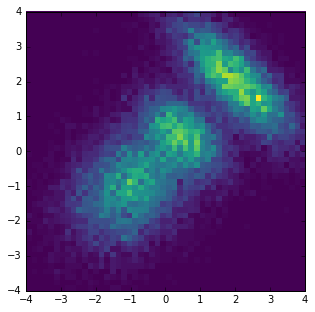

In [54]:
X_true = p_H1.rvs(25000)
plot_data(X_true)

## Maximum likelihood estimator for H0

First, let us find the maximum likelihood estimator for H0, i.e. 

$$\hat \theta = \arg \max_{\nu \in \Theta_0} p(D|\nu) = \arg \max_{\nu \in \Theta_0} \frac{p(D|\nu)}{p(D|\theta_1)},$$ 

where $p(D|\theta_1)$ is some arbitrary density covering $p(D|\nu)$. This form allows us to use likelihood ratio estimators for solving the inference problem.

In particular, we have $\frac{p(D|\nu)}{p(D|\theta_1)} = \frac{p(s(D;\nu,\theta_1)|\nu)}{p(s(D;\nu,\theta_1)|\theta_1)}$, where $s(D;\nu,\theta_1)$ is a family of classifiers parameterized by $\nu$ and $\theta_1$. As outlined in [1], we here train a single parameterized classifier:

In [55]:
from sklearn.model_selection import ParameterGrid

def append(X, values, mapping):
    X_param = np.zeros((len(X), len(values)))
    
    for p, v in values.items():
        X_param[:, mapping[p]] = v
        
    return np.hstack((X, X_param))

def build_Xy(p0, p1, params={}, n_samples=16):
    param_to_col = {}
    name_to_param = {}
    
    for j, p in enumerate(params):
        param_to_col[p] = j
        name_to_param[p.name] = p
    
    grid = list(ParameterGrid({k.name:v for k, v in params.items()}))
    n_samples = int(n_samples / len(grid))
    n_samples0 = n_samples // 2
    n_samples1 = n_samples - n_samples0
    
    all_X = []
    all_y = []
    
    y = np.zeros(n_samples)
    y[n_samples0:] = 1
    
    for values in grid:       
        for p, j in param_to_col.items():
            p.set_value(values[p.name])
            
        X = np.vstack((p0.rvs(n_samples0), 
                       p1.rvs(n_samples1)))
        
        X = append(X, {name_to_param[name]:v for name, v in values.items()}, param_to_col)
        
        all_X.append(X)
        all_y.append(y)
        
    return np.vstack(all_X), np.concatenate(all_y), param_to_col

In [56]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from carl.ratios.cc import as_classifier

u = MultivariateNormal(mu=np.array([0., 0.]), sigma=10 * np.eye(2))  # this is p(D|theta_1)
X, y, mapping = build_Xy(p_H0, u, 
                         params={nu: np.linspace(nu_bounds[0], nu_bounds[1], num=10)}, 
                         n_samples=100000)

clf = make_pipeline(
    StandardScaler(),
    as_classifier(MLPRegressor(hidden_layer_sizes=(50, 50, 50), 
                               activation="tanh")))
clf = clf.fit(X, y)

Given $s$, we can now find the maximum likelihood estimator:

In [57]:
from carl.distributions import Histogram
import itertools

def objective(X, clf, mapping, p0, p1, params, n_samples=25000):
    for p, v in params.items():
        p.set_value(v)

    # Here we embed the calibration of s(x;\theta_0,\theta_1) 
    # A more effective approach would be to have a single parameterized calibration
    s_0 = clf.predict_proba(append(p0.rvs(n_samples // 2), params, mapping))[:, 0]
    s_1 = clf.predict_proba(append(p1.rvs(n_samples // 2), params, mapping))[:, 0]
    cal_0 = Histogram(bins=100, range=[(0.0, 1.0)]).fit(s_0.reshape(-1, 1))
    cal_1 = Histogram(bins=100, range=[(0.0, 1.0)]).fit(s_1.reshape(-1, 1))
    
    s_X = clf.predict_proba(append(X, params, mapping))[:, 0]
    s_X = s_X.reshape(-1, 1)
    
    ratios = np.zeros(len(X))

    logp_num = -cal_0.nnlf(s_X)
    logp_den = -cal_1.nnlf(s_X)
    mask = logp_num != logp_den
    ratios[mask] += logp_num[mask] - logp_den[mask]
    
    return np.mean(ratios[np.isfinite(ratios)])  # avoid numerical issues

def scan(f, params):
    params = [(k, v) for k, v in params.items()]
    order = [k for k, _ in params]
    grid = {k:[] for k, _ in params}
    values = []
    
    for x in itertools.product(*[v for _, v in params]):   
        d = {}
        for i, v in enumerate(x):
            grid[order[i]].append(v)
            d[order[i]] = v
        values.append(f(d))
        
    grid = {k: np.array(v) for k, v in grid.items()}
    values = np.array(values)
  
    return grid, values, order

In [58]:
# Likelihood scan
nu_range = np.linspace(nu_bounds[0], nu_bounds[1], num=51)
grid, values, _ = scan(lambda d: objective(X_true, clf, mapping, p_H0, u, d),
                       {nu: nu_range})

def argmax(array):
    array = array.copy()
    m = ~np.isfinite(array)
    array[m] = -np.inf
    return np.argmax(array)

i = argmax(values)
nu_hat_H0 = grid[nu][i]

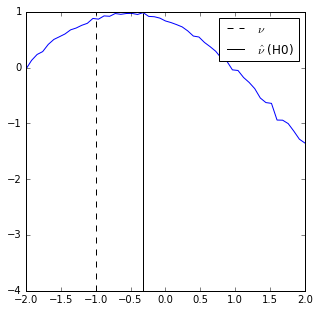

In [59]:
plt.plot(grid[nu], values)
plt.vlines(nu_true, ymin=-4, ymax=1.0, linestyles="dashed", label=r"$\nu$")
plt.vlines(nu_hat_H0, ymin=-4, ymax=values[i], linestyles="solid", label=r"$\hat\nu$ (H0)")
plt.legend()
plt.show()

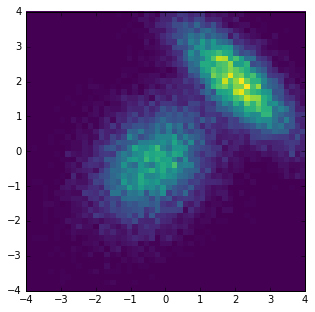

In [60]:
nu.set_value(nu_hat_H0)
plot_data(p_H0.rvs(25000))  # Best fit under H0 of X_true

In [61]:
nu_hat_H0

-0.32000000000000006

## Maximum likelihood estimator for H1

Using the same approach, we can find the maximum likelihood estimators for H1:

In [62]:
u = MultivariateNormal(mu=np.array([0., 0.]), sigma=10 * np.eye(2))
X, y, mapping = build_Xy(p_H1, u, 
                         params={nu: np.linspace(nu_bounds[0], nu_bounds[1], num=10),
                                 alpha: np.linspace(alpha_bounds[0], alpha_bounds[1], num=10)}, 
                         n_samples=100000)

clf = make_pipeline(
    StandardScaler(),
    as_classifier(MLPRegressor(hidden_layer_sizes=(50, 50, 50), 
                               activation="tanh")))
clf = clf.fit(X, y)

In [63]:
nu_range = np.linspace(nu_bounds[0], nu_bounds[1], num=31)
alpha_range = np.linspace(alpha_bounds[0], alpha_bounds[1], num=31)
grid, values, order = scan(lambda d: objective(X_true, clf, mapping, p_H1, u, d),
                           {nu: nu_range,
                            alpha: alpha_range})

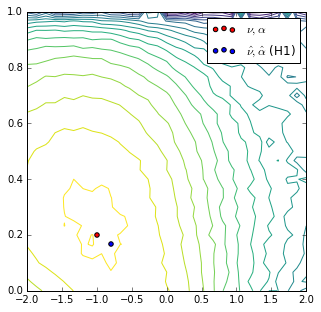

In [64]:
i = argmax(values)
nu_hat_H1 = grid[nu][i]
alpha_hat_H1 = grid[alpha][i]

x = grid[nu].reshape(len(nu_range), len(alpha_range))   # FIXME: guarantee the correct order
y = grid[alpha].reshape(len(nu_range), len(alpha_range)) 
z = values.reshape(len(nu_range), len(alpha_range)) 

plt.contour(x, y, z, 20)
plt.scatter([nu_true], [alpha_true], label=r"$\nu,\alpha$", c="r", marker="o")
plt.scatter([nu_hat_H1], [alpha_hat_H1], label=r"$\hat\nu,\hat\alpha$ (H1)", c="b", marker="o")
plt.xlim(nu_bounds[0], nu_bounds[1])
plt.ylim(alpha_bounds[0], alpha_bounds[1])
plt.legend()
plt.show()

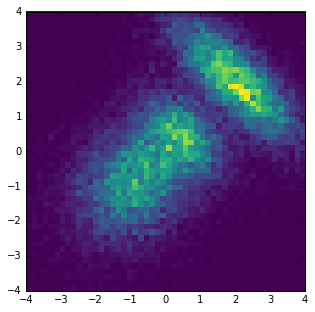

In [65]:
nu.set_value(nu_hat_H1)
alpha.set_value(alpha_hat_H1)
plot_data(p_H1.rvs(25000))  # Best fit under H1 of X_true

In [66]:
nu_hat_H1, alpha_hat_H1

(-0.80000000000000004, 0.16666666666666666)

## Likelihood ratio test

Now that the maximum likelihood estimators have been found for both the numerator and the denominator, the likelihood ratio can be approximated at the obtained values, as in the simple hypothesis setting (see previous notebook).

In [67]:
p_H0 = Mixture(components=[
    MultivariateNormal(mu=nu_hat_H0 * np.array([1.0, 1.0]), 
                       sigma=np.array([[1.0, 0.3], 
                                       [0.3, 1.0]])),    
    MultivariateNormal(mu=np.array([2.0, 2.0]), 
                       sigma=np.array([[1.0, -0.75], 
                                       [-0.75, 1.0]]))])

p_H1 = Mixture(components=[
    Mixture(components=[
        MultivariateNormal(mu=nu_hat_H1 * np.array([1.0, 1.0]), 
                           sigma=np.array([[1.0, 0.3], 
                                           [0.3, 1.0]])),    
        MultivariateNormal(mu=np.array([2.0, 2.0]), 
                           sigma=np.array([[1.0, -0.75], 
                                           [-0.75, 1.0]]))]), 
    MultivariateNormal(mu=np.array([0.5, 0.5]), sigma=np.array([[0.5, -0.25], 
                                                               [-0.25, 0.5]]))], 
    weights=[1.0 - alpha_hat_H1, alpha_hat_H1])

/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


<a list of 23 text.Text objects>

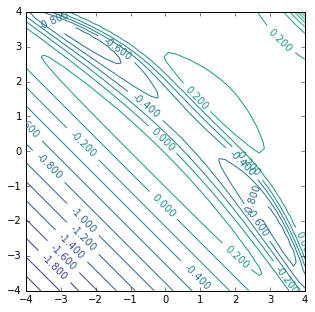

In [138]:
# True likelihood ratio
XX, YY = np.meshgrid(np.linspace(-4, 4, num=50), np.linspace(-4, 4, num=50))
g = np.hstack((XX.reshape(-1, 1), YY.reshape(-1, 1)))
Z = -p_H0.nnlf(g) + p_H1.nnlf(g)
cs = plt.contour(XX, YY, Z.reshape(XX.shape), 20, vmin=-3.0, vmax=3.0)
plt.clabel(cs, inline=1, fontsize=10)

In [136]:
from carl.ratios import CalibratedClassifierRatio
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import StratifiedShuffleSplit
from carl.ratios import DecomposedRatio
from carl.distributions import KernelDensity

cv = StratifiedShuffleSplit(n_iter=3, test_size=0.5)
cc_decomposed = DecomposedRatio(CalibratedClassifierRatio(base_estimator=MLPRegressor(hidden_layer_sizes=(20, 20)), 
                                                          calibration=KernelDensity(bandwidth=0.2), cv=cv))
cc_decomposed.fit(numerator=p_H0, denominator=p_H1, n_samples=200000)

DecomposedRatio(base_ratio=CalibratedClassifierRatio(base_estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(20, 20),
       learning_rate='constant', learning_rate_init=0.001, max... cv=StratifiedShuffleSplit(n_iter=3, random_state=None, test_size=0.5,
            train_size=None)))

<a list of 30 text.Text objects>

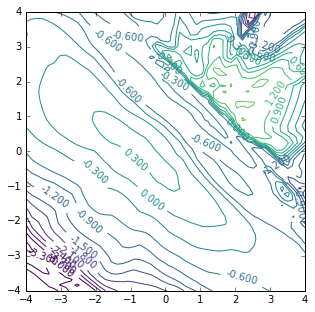

In [137]:
# Approximate likelihood ratio
Z = cc_decomposed.predict(g, log=True)
cs = plt.contour(XX, YY, Z.reshape(XX.shape), 20, vmin=-3.0, vmax=3.0)
plt.clabel(cs, inline=1, fontsize=10)